In [23]:
from __future__ import print_function
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import json
from tqdm import *
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model, print_summary
from IPython.display import Image
tqdm.monitor_interval = 0
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"

In [24]:
from numpy import linspace
from matplotlib import cm

start = 0.0
stop = 1.0
number_of_lines= 5
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.viridis(x) for x in cm_subsection ]

In [25]:
pad_length = 2500
# best model
LSTM_numb = 512
dr = 0.03
lr = 0.008
b = 64

In [4]:
jsonObj = json.load(open("all_text_sessions.json", "r"))
sessions = []
session_ids = []
for s in jsonObj:
    sessions.append(s['actions'])
    session_ids.append(s['id'])

In [5]:
from gensim.corpora.dictionary import Dictionary
import json
from gensim import models
import os

In [6]:
dictionary = Dictionary(sessions)
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in sessions]

Dictionary(174 unique tokens: ['getresuid', 'setgid', 'alarm', 'lsetxattr', 'mq_notify']...)


In [7]:
safe_model = "model_8topics_adfald"
if os.path.isfile(safe_model):
    lda = models.LdaModel.load(safe_model)
else:
    lda = models.LdaModel(corpus, num_topics=8)
    lda.save(safe_model)

In [8]:
per_topic_sessions = {}
per_topic_session_ids = {}
i = 0
for s in corpus:
    vector = lda[s]
    maxm = 0
    maxt = 0
    for t in vector:
        if t[1] > maxm:
            maxm = t[1]
            maxt = t[0]
    if per_topic_sessions.get(maxt) is None:
        per_topic_sessions[maxt] = 1
        per_topic_session_ids[maxt] = [session_ids[i]]
    else:
        per_topic_sessions[maxt] += 1
        per_topic_session_ids[maxt].append(session_ids[i])
    i += 1
print(per_topic_sessions)

{0: 22, 1: 24, 2: 83, 3: 437, 4: 4150, 5: 65, 6: 393, 7: 32}


In [9]:
if not os.path.isfile("lda_topics_adfald.json"):
    json.dump(per_topic_session_ids, open("lda_topics_adfald.json", "w"))

In [10]:
import codecs

f = "sc.txt"
syscall_names = []
global actions 
global action_indices
global indices_action
for l in codecs.open(f, "r").readlines():
    syscall_names.append(l.split("\t")[1].replace("\n", "").replace("\r", ""))
# create dictionaries with actions and their indexing for further transformation to
# one-hot-encoding and back
actions = syscall_names
print('total actions:', len(actions))
action_indices = dict((c, i) for i, c in enumerate(actions))
indices_action = dict((i, c) for i, c in enumerate(actions))

total actions: 341


In [11]:
def generic_data(num_sessions = None):
    # logged sessions from Amadeus system
    seqs = []
    jsonObj = json.load(open("all_text_sessions.json", "r"))
    for s in jsonObj:
        seqs.append(s['actions'])

    print('corpus length:', len(seqs))
    
    # cut too long sessions to maximal size of pad_length
    # throw away sessions less than 3 actions long
    input_seqs = []
    next_acts = []
    for seq in seqs:
        if len(seq) > pad_length:
            input_seqs.append(seq[:pad_length-1])
            next_acts.append(seq[pad_length-1])
        if len(seq) <= pad_length and len(seq) > 2:
            pad_len = pad_length - len(seq)
            pad_seq = [None] * pad_len
            pad_seq.extend(seq[:-1])
            input_seqs.append(pad_seq)
            next_acts.append(seq[-1])
    #print('nb inputs:', len(input_seqs))
    
    # transform sequences and labels to one-hot-encoding vectors
    x = []
    y = []
    for i, inp in enumerate(input_seqs):
        vector_seq = np.zeros((len(inp),len(actions)))
        for t, action in enumerate(inp):
            if action is not None:
                vector_seq[t, action_indices[action]] = 1
        x.append(vector_seq)
        vector_label = np.zeros((len(actions)))
        vector_label[action_indices[next_acts[i]]] = 1
        y.append(vector_label)
    
    #taking random num_sessions
    if num_sessions is not None:
        print("Selected data ", num_sessions)
        idx = np.random.randint(len(x), size=num_sessions)
        x = np.asarray(x)
        x = x[idx,:,:]
    
    # separate into training, val and testing parts
    train_size = int(round(len(x)*0.7))
    val_size = int(round(len(x)*0.85))
    x_train = np.asarray(x[:train_size])
    y_train = np.asarray(y[:train_size])
    x_val = np.asarray(x[train_size:val_size])
    y_val = np.asarray(y[train_size:val_size])
    x_test = np.asarray(x[val_size:])
    y_test = np.asarray(y[val_size:])
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [12]:
x_train, y_train, x_val, y_val, x_test, y_test = generic_data()

corpus length: 5206


In [13]:
np.random.seed(42)
K.tf.set_random_seed(42)

if os.path.isfile('generic_model_10epochs_adfald.h5'):
    model = load_model('generic_model_10epochs_adfald.h5')
else:
    print('Build generic model...')
    stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                                             verbose=1, mode='auto')

    model = Sequential()
    # have several parameters to choose with meta-parametrization optimization
    model.add(LSTM(LSTM_numb, input_shape=(None, len(actions))))
    model.add(Dropout(dr))
    model.add(Dense(len(actions)))
    model.add(Activation('softmax'))
    optimizer = Adam(lr=lr)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= optimizer)

    hist = model.fit(x=x_train, y=y_train, batch_size=b, epochs=10, verbose=2, callbacks=[stopping], 
                     validation_split=0.15, shuffle=True, initial_epoch=0)

    model.save('generic_model_10epochs_adfald.h5')

In [14]:
model.evaluate(x_test, y_test)

781/781 [==============================] - 42s 54ms/step


[1.6667772545246706, 0.5198463510230622]

In [15]:
def cluster_data(cluster_topic):
    with open('lda_topics_adfald.json') as f:
        data = json.load(f)
        sessionPFXs = data[cluster_topic]

    # not every log line will have sequence of actions
    seqs = []
    c = 0
    for s in sessions:
        if session_ids[c] in sessionPFXs:
            seqs.append(s)
        c += 1
    print('corpus length:', len(seqs))    
    
    # cut too long sessions to maximal size of pad_length
    # throw away sessions less than 3 actions long
    input_seqs = []
    next_acts = []
    test_seqs = []
    for seq in seqs:
        if len(seq) > 2:
            test_seqs.append(seq)
        if len(seq) > pad_length:
            input_seqs.append(seq[:pad_length-1])
            next_acts.append(seq[pad_length-1])
        if len(seq) <= pad_length and len(seq) > 2:
            pad_len = pad_length - len(seq)
            pad_seq = [None] * pad_len
            pad_seq.extend(seq[:-1])
            input_seqs.append(pad_seq)
            next_acts.append(seq[-1])
    print('nb inputs:', len(input_seqs))
    
    # transform sequences and labels to one-hot-encoding vectors
    x = []
    y = []
    test_s = []
    for i, inp in enumerate(input_seqs):
        vector_seq = np.zeros((len(inp),len(actions)))
        for t, action in enumerate(inp):
            if action is not None:
                vector_seq[t, action_indices[action]] = 1
        x.append(vector_seq)
        vector_label = np.zeros((len(actions)))
        vector_label[action_indices[next_acts[i]]] = 1
        y.append(vector_label)
        v_t_seq = np.zeros((len(test_seqs[i]),len(actions)))
        for t, action in enumerate(test_seqs[i]):
            if action is not None:
                v_t_seq[t, action_indices[action]] = 1
        test_s.append(v_t_seq)
    test_s = np.asarray(test_s[int(round(len(test_s)*0.85)):])
    test_seqs = np.asarray(test_seqs[int(round(len(test_seqs)*0.85)):])
        
    # separate into training, val and testing parts
    train_size = int(round(len(x)*0.7))
    val_size = int(round(len(x)*0.85))
    x_train = np.asarray(x[:train_size])
    y_train = np.asarray(y[:train_size])
    x_val = np.asarray(x[train_size:val_size])
    y_val = np.asarray(y[train_size:val_size])
    x_test = np.asarray(x[val_size:])
    y_test = np.asarray(y[val_size:])
    
    return x_train, y_train, x_val, y_val, x_test, y_test, test_seqs, test_s

In [16]:
clusters = [str(e) for e in range(8)]
clusters_datasets = {}
for cluster_topic in clusters:
    print(cluster_topic)
    clusters_datasets[cluster_topic] = cluster_data(cluster_topic)

0
corpus length: 126
nb inputs: 126
1
corpus length: 47
nb inputs: 47
2
corpus length: 319
nb inputs: 319
3
corpus length: 651
nb inputs: 651
4
corpus length: 1834
nb inputs: 1834
5
corpus length: 171
nb inputs: 171
6
corpus length: 438
nb inputs: 438
7
corpus length: 1620
nb inputs: 1620


In [17]:
np.random.seed(42)
K.tf.set_random_seed(42)

clusters_models = {}
random_models = {}
clusters_eval_losses = {}
clusters_eval_perplexities = {}
clusters_eval_accuracies = {}
for cluster_topic in clusters_datasets:
    print(cluster_topic)
    # cluster model
    stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                                         verbose=1, mode='auto')
    cluster_model = Sequential()
    # have several parameters to choose with meta-parametrization optimization
    cluster_model.add(LSTM(LSTM_numb, input_shape=(None, len(actions))))
    cluster_model.add(Dropout(dr))
    cluster_model.add(Dense(len(actions)))
    cluster_model.add(Activation('softmax'))
    optimizer = Adam(lr=lr)

    cluster_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= optimizer)

    c_hist = cluster_model.fit(x=clusters_datasets[cluster_topic][0], y=clusters_datasets[cluster_topic][1], batch_size=b, 
                               epochs=10, verbose=0, callbacks=[stopping], 
                               validation_data=(clusters_datasets[cluster_topic][2], clusters_datasets[cluster_topic][3]), 
                               shuffle=True, initial_epoch=0)
    
    local_eval = cluster_model.evaluate(clusters_datasets[cluster_topic][4], clusters_datasets[cluster_topic][5], verbose=0)
    
    clusters_models[cluster_topic] = cluster_model
    
    # random subset model
    xg_train, yg_train, xg_val, yg_val, xg_test, yg_test = generic_data(num_sessions = 
                                                                        len(clusters_datasets[cluster_topic][0]) + 
                                                                        len(clusters_datasets[cluster_topic][2]) + 
                                                                        len(clusters_datasets[cluster_topic][4]))

    gen_model = Sequential()
    # have several parameters to choose with meta-parametrization optimization
    gen_model.add(LSTM(LSTM_numb, input_shape=(None, len(actions))))
    gen_model.add(Dropout(dr))
    gen_model.add(Dense(len(actions)))
    gen_model.add(Activation('softmax'))
    optimizer = Adam(lr=lr)

    gen_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= optimizer)

    g_hist = gen_model.fit(x=xg_train, y=yg_train, batch_size=b, epochs=10, verbose=0, 
                           callbacks=[stopping], validation_data=(xg_val, yg_val), shuffle=True, initial_epoch=0)
    
    random_models[cluster_topic] = gen_model
    
    # evaluate
    global_eval = model.evaluate(clusters_datasets[cluster_topic][4], clusters_datasets[cluster_topic][5], verbose=0)
    random_eval = gen_model.evaluate(clusters_datasets[cluster_topic][4], clusters_datasets[cluster_topic][5], verbose=0)
    clusters_eval_losses[cluster_topic] = [local_eval[0], global_eval[0], random_eval[0]]
    clusters_eval_accuracies[cluster_topic] = [local_eval[1], global_eval[1], random_eval[1]]

7
corpus length: 5206
Selected data  1620
3
corpus length: 5206
Selected data  651
2
corpus length: 5206
Selected data  319
1
corpus length: 5206
Selected data  47
4
corpus length: 5206
Selected data  1834
0
corpus length: 5206
Selected data  126
5
corpus length: 5206
Selected data  171
6
corpus length: 5206
Selected data  438


In [18]:
import operator

cluster_lengths = {}
for cluster in clusters_datasets:
    cluster_lengths[cluster] = len(clusters_datasets[cluster][0])
ordered_cluster_lengths = sorted(cluster_lengths.items(), key=operator.itemgetter(1))
ordered_by_lengths = [e[0] for e in ordered_cluster_lengths]

In [19]:
import pickle

if not os.path.isfile("lda_eval_losses_adfald"):
    pickle.dump(clusters_eval_losses, open("lda_eval_losses_adfald", "wb"))
    pickle.dump(clusters_eval_accuracies, open("lda_eval_accuracies_adfald", "wb"))

In [20]:
cluster_names = []
for i in range(len(ordered_by_lengths)):
    cluster_names.append("Cluster" + str(i+1))

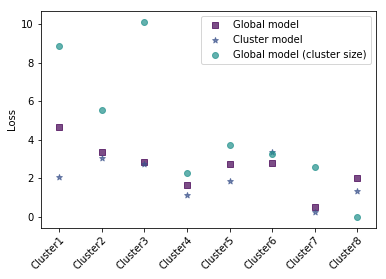

In [21]:
losses_gl = []
losses_cl = []
losses_rn = []
for c in ordered_by_lengths:
    losses_gl.append(clusters_eval_losses[c][1])
    losses_rn.append(clusters_eval_losses[c][2])
    losses_cl.append(clusters_eval_losses[c][0])
    
fig, ax = plt.subplots()
plt.scatter(range(len(ordered_by_lengths)), losses_gl, c=[colors[0]], marker='s', alpha=0.7, label='Global model')
plt.scatter(range(len(ordered_by_lengths)), losses_cl, c=[colors[1]], marker='*', alpha=0.7, label='Cluster model')
plt.scatter(range(len(ordered_by_lengths)), losses_rn, c=[colors[2]], alpha=0.7, label='Global model (cluster size)')
ax.set_xticks(np.arange(len(ordered_by_lengths)))
ax.set_xticklabels(cluster_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Loss")
plt.legend()
plt.show()

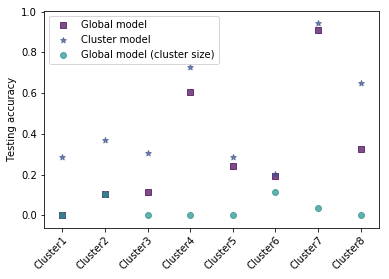

In [26]:
acc_gl = []
acc_cl = []
acc_rn = []
for c in ordered_by_lengths:
    acc_gl.append(clusters_eval_accuracies[c][1])
    acc_rn.append(clusters_eval_accuracies[c][2])
    acc_cl.append(clusters_eval_accuracies[c][0])
    
fig, ax = plt.subplots()
plt.scatter(range(len(ordered_by_lengths)), acc_gl, c=[colors[0]], marker='s', alpha=0.7, label='Global model')
plt.scatter(range(len(ordered_by_lengths)), acc_cl, c=[colors[1]], marker='*', alpha=0.7, label='Cluster model')
plt.scatter(range(len(ordered_by_lengths)), acc_rn, c=[colors[2]], alpha=0.7, label='Global model (cluster size)')
ax.set_xticks(np.arange(len(ordered_by_lengths)))
ax.set_xticklabels(cluster_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel("Testing accuracy")
plt.legend()
plt.show()

In [23]:
accuracies = []
own_vs_avg = []
for cluster_topic in ordered_by_lengths:
    print(cluster_topic)
    accuracies.append([])
    own_vs_avg.append([0,0])
    for test in ordered_by_lengths:
        ac = clusters_models[cluster_topic].evaluate(clusters_datasets[test][4], clusters_datasets[test][5], verbose=0)[1]
        accuracies[-1].append(ac)
        if cluster_topic == test:
            own_vs_avg[-1][0] = ac
        else:
            own_vs_avg[-1][1] += ac
    own_vs_avg[-1][1] /= 7.0

1
0
5
2
6
3
7
4


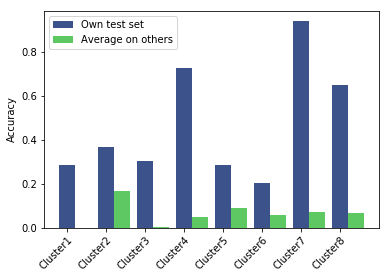

In [24]:
x = np.arange(len(cluster_names))
plt.bar(x, [e[0] for e in own_vs_avg],width=0.4,color=colors[1],align='center', label='Own test set')
plt.bar(x+0.4, [e[1] for e in own_vs_avg],width=0.4,color=colors[3],align='center', label='Average on others')
plt.legend()
plt.ylabel("Accuracy")
plt.xticks(x, cluster_names, rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

In [25]:
import pickle

if not os.path.isfile("own_vs_avg_accuracies_lda_adfald"):
    pickle.dump(own_vs_avg, open("own_vs_avg_accuracies_lda_adfald", "wb"))

In [29]:
jsonObj = json.load(open("attack_text_sessions.json", "r"))
attack_sessions = []
for s in jsonObj:
    attack_sessions.append(s['actions']) 

# cut too long sessions to maximal size of pad_length
# throw away sessions less than 3 actions long
attack_test_seqs = []
for seq in attack_sessions:
    if len(seq) > 2:
        attack_test_seqs.append(seq)
print('nb inputs:', len(attack_test_seqs))

# transform sequences and labels to one-hot-encoding vectors
attack_test_s = []
for i, inp in enumerate(attack_test_seqs):
    v_t_seq = np.zeros((len(attack_test_seqs[i]),len(actions)))
    for t, action in enumerate(attack_test_seqs[i]):
        if action is not None:
            v_t_seq[t, action_indices[action]] = 1
    attack_test_s.append(v_t_seq)

nb inputs: 746


In [36]:
attack_predictions = []
for i in tqdm(range(len(attack_test_s))):
    session = attack_test_s[i]
    t_session = attack_test_seqs[i]
    scores = []
    losses = []
    lda_predictions = []
    gl_losses = []
    gl_scores = []
    max_clusters = []
    max_cluster_scores = []
    max_losses = []
    to_eval = min([100, len(session)])
    for j in range(to_eval):
        if j >= 4:
            vector = lda[dictionary.doc2bow(t_session[:j])]
            for t in vector:
                if t[0] == int(test_cl):
                    lda_predictions.append(t[1])

            cur_evaluation = session[:j]
            cur_pred = session[j]
            if len(cur_evaluation) < pad_length-1:
                pad_len = pad_length-1 - len(cur_evaluation)
                pad_seq = np.zeros((pad_len, len(actions))).tolist()
                pad_seq.extend(cur_evaluation)
                cur_evaluation = np.array(pad_seq)
            if len(cur_evaluation) > pad_length-1:
                cur_evaluation = np.array(cur_evaluation[-(pad_length-1):])

            gl_losses.append(model.evaluate(np.array([cur_evaluation]), np.array([cur_pred]), verbose=0)[0])
            gl_scores.append(model.predict(np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])

            maxm = 0
            maxt = 0
            for t in vector:
                if t[1] > maxm:
                    maxm = t[1]
                    maxt = t[0]
            max_clusters.append(maxm)
            max_cluster_scores.append(clusters_models[str(maxt)].predict(
                np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])  
            max_losses.append(clusters_models[str(maxt)].evaluate(np.array([cur_evaluation]), 
                                                                    np.array([cur_pred]), verbose=0)[0])
    attack_predictions.append([lda_predictions, gl_losses, gl_scores, 
                            max_clusters, max_cluster_scores, max_losses])

100%|██████████| 746/746 [57:00:35<00:00, 275.12s/it]   


In [43]:
if not os.path.isfile("attack_predictions_lda_adfald"):
    pickle.dump(attack_predictions, open("attack_predictions_lda_adfald", "wb"))

In [ ]:
from collections import Counter

predictions = {}
for test_cl in ordered_by_lengths:
    print(test_cl)
    predictions[test_cl] = []
    local_model = clusters_models[test_cl]
    rnd_model = random_models[test_cl]
    for i in tqdm(range(len(clusters_datasets[test_cl][6]))):
        session = clusters_datasets[test_cl][7][i]
        session = np.array(session)
        t_session = clusters_datasets[test_cl][6][i]
        #scores = []
        #losses = []
        lda_predictions = []
        gl_losses = []
        gl_scores = []
        max_clusters = []
        max_cluster_scores = []
        max_losses = []
        to_eval = min([100, len(session)])
        for j in range(to_eval):
            if j >= 4:
                vector = lda[dictionary.doc2bow(t_session[:j])]
                for t in vector:
                    if t[0] == int(test_cl):
                        lda_predictions.append(t[1])
                        
                cur_evaluation = session[:j]
                cur_pred = session[j]
                if len(cur_evaluation) < pad_length-1:
                    pad_len = pad_length-1 - len(cur_evaluation)
                    pad_seq = np.zeros((pad_len, len(actions))).tolist()
                    pad_seq.extend(cur_evaluation)
                    cur_evaluation = np.array(pad_seq)
                if len(cur_evaluation) > pad_length-1:
                    cur_evaluation = np.array(cur_evaluation[-(pad_length-1):])
                
                #scores.append(local_model.predict(np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])
                #losses.append(local_model.evaluate(np.array([cur_evaluation]), np.array([cur_pred]), verbose=0)[0])
                gl_losses.append(model.evaluate(np.array([cur_evaluation]), np.array([cur_pred]), verbose=0)[0])
                gl_scores.append(model.predict(np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])
                
                maxm = 0
                maxt = 0
                for t in vector:
                    if t[1] > maxm:
                        maxm = t[1]
                        maxt = t[0]
                max_clusters.append(maxm)
                max_cluster_scores.append(clusters_models[str(maxt)].predict(
                    np.array([cur_evaluation]))[0][np.array(cur_pred).argmax()])  
                max_losses.append(clusters_models[str(maxt)].evaluate(np.array([cur_evaluation]), 
                                                                        np.array([cur_pred]), verbose=0)[0])
        predictions[test_cl].append([lda_predictions, #scores, losses, 
                                     gl_losses, gl_scores, 
                                max_clusters, max_cluster_scores, max_losses])

In [ ]:
if not os.path.isfile("predictions_lda_adfald"):
    pickle.dump(predictions, open("predictions_lda_adfald", "wb"))

In [26]:
#0 lda_predictions, 1 gl_losses, 2 gl_scores, 
#3 max_clusters, 4 max_cluster_scores, 5 max_losses
lda_test_predictions = pickle.load(open("predictions_lda_adfald", "rb"))
print(len(lda_test_predictions))
lda_attack_predictions = pickle.load(open("attack_predictions_lda_adfald", "rb"))
print(len(lda_attack_predictions))

lda_cl_scores = []
lda_gl_scores = []
lda_labels = []
for s in lda_attack_predictions:
    if len(s[4]) >= 1:
        lda_cl_scores.append(np.array(s[4]).mean())
        lda_gl_scores.append(np.array(s[2]).mean())
        lda_labels.append(1.0)
print(len(lda_labels))
for cl in lda_test_predictions:
    for s in lda_test_predictions[cl]:
        if len(s[4]) >= 1:
            lda_cl_scores.append(np.array(s[4]).mean())
            lda_gl_scores.append(np.array(s[2]).mean())
            lda_labels.append(0.0)
print(len(lda_labels))

8
746
746
1528


In [27]:
#0 gl_losses, 1 gl_scores, 2 max_clusters, 3 max_cluster_scores, 4 max_losses
assemblies_test_predictions = pickle.load(open("predictions_assemblies_adfald", "rb"))
print(len(assemblies_test_predictions))
#0 max_clusters, 1 max_cluster_scores, 2 max_losses
assemblies_attack_predictions = pickle.load(open("attack_predictions_assemblies_adfald", "rb"))
print(len(assemblies_attack_predictions))

assemblies_cl_scores = []
assemblies_gl_scores = []
assemblies_clustering_scores = []
assemblies_labels = []
i = 0
for s in assemblies_attack_predictions:
    if len(s[1]) >= 1:
        assemblies_cl_scores.append(np.array(s[1]).mean())
        assemblies_gl_scores.append(np.array(lda_attack_predictions[i][2]).mean())
        assemblies_clustering_scores.append(np.array(s[0]).mean())
        assemblies_labels.append(1.0)
        i += 1
print(len(assemblies_labels))
for cl in assemblies_test_predictions:
    for s in assemblies_test_predictions[cl]:
        if len(s[1]) >= 1:
            assemblies_cl_scores.append(np.array(s[3]).mean())
            assemblies_gl_scores.append(np.array(s[1]).mean())
            assemblies_clustering_scores.append(np.array(s[2]).mean())
            assemblies_labels.append(0.0)
print(len(assemblies_labels))

11
746
746
1527


In [33]:
#0 kmeans_predictions, 1 gl_losses, 2 gl_scores, 3 max_cluster_scores, 4 max_losses
kmeans_test_predictions = pickle.load(open("predictions_kmeans_adfald", "rb"))
print(len(kmeans_test_predictions))
#0 kmeans_predictions, 1 max_clusters, 2 max_cluster_scores, 3 max_losses
kmeans_attack_predictions = pickle.load(open("attack_predictions_kmeans_adfald", "rb"))
print(len(kmeans_attack_predictions))

kmeans_cl_scores = []
kmeans_gl_scores = []
kmeans_labels = []
i = 0
for s in kmeans_attack_predictions:
    if len(s[2]) >= 1:
        kmeans_cl_scores.append(np.array(s[2]).mean())
        kmeans_gl_scores.append(np.array(lda_attack_predictions[i][2]).mean())
        kmeans_labels.append(1.0)
        i += 1
print(len(kmeans_labels))
for cl in kmeans_test_predictions:
    for s in kmeans_test_predictions[cl]:
        if len(s[1]) >= 1:
            kmeans_cl_scores.append(np.array(s[3]).mean())
            kmeans_gl_scores.append(np.array(s[2]).mean())
            kmeans_labels.append(0.0)
print(len(kmeans_labels))

4
3
1
746
746
1526


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

fprs = []
tprs = []
roc_aucs = []

for sc in [lda_gl_scores, lda_cl_scores]:
    fpr, tpr, thresholds = roc_curve(lda_labels, sc)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    
for sc in [assemblies_gl_scores, assemblies_cl_scores, assemblies_clustering_scores]:
    fpr, tpr, thresholds = roc_curve(assemblies_labels, sc)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
        
for sc in [kmeans_gl_scores, kmeans_cl_scores]:
    fpr, tpr, thresholds = roc_curve(kmeans_labels, sc)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

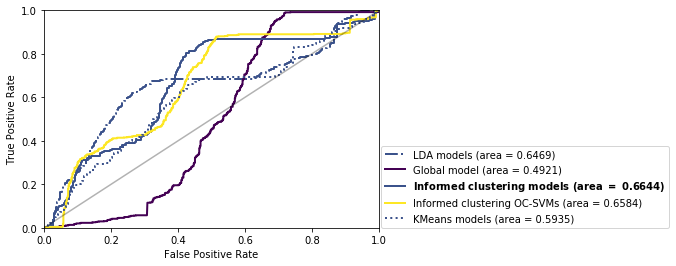

In [48]:
#0 lda_gl_scores, 1 lda_cl_scores
#2 assemb_gl_scores, 3 assemb_cl_scores, 4 assemb_clustering_scores
#5 kmeans_gl_scores, 6 kmeans_cl_scores

plt.figure()
lw = 2
plt.plot(fprs[1], tprs[1], lw=lw, c=colors[1], linestyle='-.', label='LDA models (area = %0.4f)' % roc_aucs[1])
plt.plot(fprs[2], tprs[2], lw=lw, c=colors[0], label='Global model (area = %0.4f)' % roc_aucs[2])
plt.plot(fprs[3], tprs[3], lw=lw, c=colors[1], label=r"$\bf{Informed\ clustering\ models\ (area\ =\ %0.4f)}$" % roc_aucs[3])
plt.plot(fprs[4], tprs[4], lw=lw, c=colors[4], label='Informed clustering OC-SVMs (area = %0.4f)' % roc_aucs[4])
plt.plot(fprs[6], tprs[6], lw=lw, c=colors[1], linestyle=':', label='KMeans models (area = %0.4f)' % roc_aucs[6])
plt.plot([0, 1], [0, 1], color='black', alpha=0.3, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=(1.005, 0.001))
plt.show()